---
title: "重新認識pytorch(2)"
subtitle: "了解RNN"
format: html
author: "紙魚"
date: "2025-08-24"
categories: [note,python,pytorch]
# format:
#   html:
#     code-fold: true
jupyter: new_env
image: "image.png"
---

RNN，全名為循環神經網路(Recurrent Neural Network)，是具有記憶功能的模型。它可以發現樣本彼此之間的相互關係，適合處理 series data 的特徵 ，可應用於處理文字資料分類及time series等。 
  
RNN 限制有：

* **梯度消失或爆炸**：RNN 訓練深層時會不穩定
* **長期依賴問題**：無法記住太久以前的資訊
* 因此實務上通常用改良版：

  * LSTM（Long Short-Term Memory）
  * GRU（Gated Recurrent Unit）

現今更常用的是 Transformer，但 RNN 在資源有限或學習原理時仍很有價值。

# RNN 的模型結構

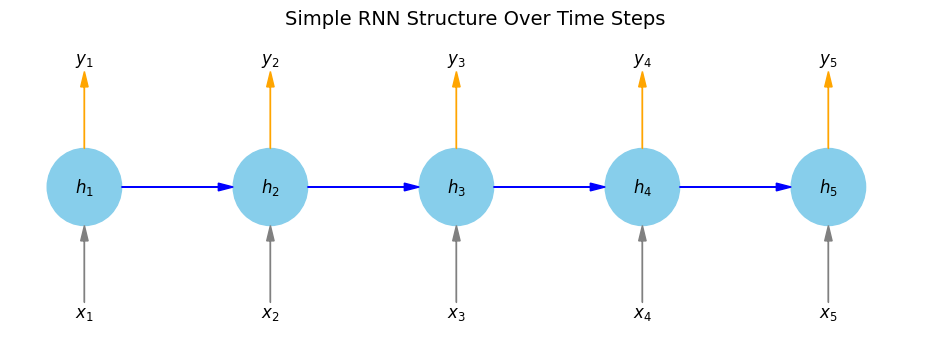

In [1]:
#| echo: false
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_rnn_diagram(seq_len=4):
    fig, ax = plt.subplots(figsize=(12, 4))
    
    radius = 0.5
    spacing = 2.5

    # 畫每個時間步 t 的節點
    for t in range(seq_len):
        x_pos = t * spacing + 1
        
        # 畫 RNN 單元 (hidden state)
        rnn = patches.Circle((x_pos, 2), radius, fill=True, color='skyblue', label='RNN cell' if t==0 else "")
        ax.add_patch(rnn)
        ax.text(x_pos, 2, f'$h_{{{t+1}}}$', ha='center', va='center', fontsize=12)

        # 畫輸入
        ax.arrow(x_pos, 0.5, 0, 1 - radius + 0.3, head_width=0.1, head_length=0.2, fc='gray', ec='gray')
        ax.text(x_pos, 0.3, f'$x_{{{t+1}}}$', ha='center', fontsize=12)

        # 畫輸出
        ax.arrow(x_pos, 2 + radius, 0, 0.8, head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        ax.text(x_pos, 3.6, f'$y_{{{t+1}}}$', ha='center', fontsize=12)

        # 畫隱藏狀態連線
        if t > 0:
            ax.arrow(x_pos - spacing + radius, 2 , spacing - 2 * radius-0.2, 0, head_width=0.1, head_length=0.2, fc='blue', ec='blue')

    # 標題與格式
    ax.set_xlim(0, seq_len * spacing)
    ax.set_ylim(0, 4)
    ax.axis('off')
    ax.set_title("Simple RNN Structure Over Time Steps", fontsize=14)

    plt.show()

draw_rnn_diagram(seq_len=5)

$\{x_t\}$表示 input；$\{y_t\}$ 表示 output； $\{h_t\}$表示 hidden layer；藍色箭頭表示依順序( 即 time series 中的 $t$ )產生的權重，在一開始還沒有東西，隨著 $t$ 增加而影響每次產生的 output

上圖為模型逐漸隨著$t = 5$增加而呈現的流程圖，如果是一般情形則如下圖：

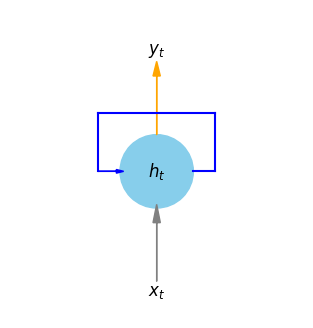

In [2]:
#| echo: false
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(6, 4))

radius = 0.5
x_pos = 3  # h_t 位置
y_pos = 2

# 畫 RNN cell (圓形)
rnn = patches.Circle((x_pos, y_pos), radius, fill=True, color='skyblue')
ax.add_patch(rnn)
ax.text(x_pos, y_pos, '$h_t$', ha='center', va='center', fontsize=12)

# 輸入箭頭
ax.arrow(x_pos, 0.5, 0, 1 - radius + 0.3, head_width=0.1, head_length=0.25, fc='gray', ec='gray')
ax.text(x_pos, 0.3, '$x_t$', ha='center', fontsize=12)

# 輸出箭頭
ax.arrow(x_pos, y_pos + radius, 0, 0.8, head_width=0.1, head_length=0.2, fc='orange', ec='orange')
ax.text(x_pos, y_pos + 1.6, '$y_t$', ha='center', fontsize=12)

# ===== 繞一圈的線段（最後一段有箭頭） =====
# 直線段：右 → 上 → 左 → 下
ax.plot([x_pos + radius, x_pos + 0.8], [y_pos, y_pos], color='blue')                       # →
ax.plot([x_pos + 0.8, x_pos + 0.8], [y_pos, y_pos + 0.8], color='blue')                   # ↑
ax.plot([x_pos + 0.8, x_pos - 0.8], [y_pos + 0.8, y_pos + 0.8], color='blue')             # ←
ax.plot([x_pos - 0.8, x_pos - 0.8], [y_pos + 0.8, y_pos], color='blue')                   # ↓

# 回到圓圈右邊（這段是箭頭）
ax.arrow(x_pos - 0.8 , y_pos ,  radius -0.25, 0, head_width=0.05, head_length=0.1, fc='blue', ec='blue')

# 格式設定
ax.set_xlim(1, 5)
ax.set_ylim(0, 4.2)
ax.set_aspect('equal')
ax.axis('off')
plt.show()


# 實作：退位減法

國小學的直式減法中，個位數不夠時會先向十位數字借位，再做減法，這種向前一位借數字再相減的動作叫做退位減法。在此我們利用退位減法，刻一個簡單 RNN ，藉此了解 RNN。退位減法的語法結構像這樣：

$$a - b = c$$

其中 a、b、c都是整數，且$a>b$，**我們的目標是a、b已知的前提下，印出來的c要是正確的**先來生成資料(a、b、c)

In [3]:
import numpy as np

np.random.seed(822)

# 省動設定
largest_number = 255  # 例如，7位元
binary_dim = 8 # 減法計算的位數

int2binary = {}
binary = np.unpackbits(
    np.array([range(2**binary_dim)], dtype=np.uint8).T, axis=1
)
for i in range(2**binary_dim):
    int2binary[i] = binary[i]

def requires_borrow(a, b):
    """檢查 a - b 是否會需要退位"""
    a_str = str(a)[::-1]  # 反轉為從低位開始
    b_str = str(b)[::-1]

    for i in range(len(b_str)):
        a_digit = int(a_str[i]) if i < len(a_str) else 0
        b_digit = int(b_str[i])
        if a_digit < b_digit:
            return True
    return False

# 資料生成
data = []
while len(data) < 10000:
    a_int = np.random.randint(2, largest_number)
    b_int = np.random.randint(1, a_int)  # 保證 b < a

    if not requires_borrow(a_int, b_int):
        continue

    a = int2binary[a_int]
    b = int2binary[b_int]
    c_int = a_int - b_int
    c = int2binary[c_int]

    data.append((a, b, c))

# data 現在包含了會需要退位的減法資料
print(f"共產生 {len(data)} 筆退位減法資料")

共產生 10000 筆退位減法資料


然後來製作模型

## 模型定義

因為是手刻，所以激勵函數及其導函數需自行指定，這裡用的 $\sigma (.)$ 是 

$\frac{1}{1+e^{-x}}$

其導數為：

$\frac{e^{-x}}{1+e^{-x}}=\frac{1}{1+e^{-x}}(1-\frac{1}{1+e^{-x}})$


In [4]:
import copy, numpy as np

# 忽略所有數值運算警告（如 overflow, invalid value 等）
np.seterr(over='ignore', invalid='ignore')


# active function
def sigmoid(x):
    output = 1/(1+np.exp(-x))
    return output

# derivative of active function
def sigmoid_output_to_deriv(output):
    return output*(1-output)

### 定義模型參數

再來定義模型參數，這裡我們將隱藏層的權重設為`synapse_0`(輸入及輸出符合 hidden dimension)；輸出層的權重設為`synapse_1`。

In [5]:
lr = 0.1
input_dim = 2 # (a, b)
hidden_dim = 16
out_dim = 1 # c


synapse_0 = (2*np.random.random((input_dim,hidden_dim))-1)*0.05
synapse_1 = (2*np.random.random((hidden_dim,out_dim))-1)*0.05
synapse_h = (2*np.random.random((hidden_dim,hidden_dim))-1)*0.05

# 反向傳遞的權重更新(平時寫在最佳化器裡)
synapse_0_up = np.zeros_like(synapse_0)
synapse_1_up = np.zeros_like(synapse_1)
synapse_h_up = np.zeros_like(synapse_h)

然後每次執行模型前應初始化模型，首次執行時 output 應為 0，總誤差應為 0。

```python
# 預測值
d = np.zeros_like(c)
overallError = 0

# 反向傳遞的誤差紀錄
layer_2_deltas = []
layer_1_values = []

layer_1_values.append(np.ones(hidden_dim)*0.1) 
# 因為一開始沒有 hidden layer 初值設為0.1
```

## 執行模型：正向

#### 任務說明（概念）

我們的目標是：
對兩個二進位數 $a$、$b$，每一個位元進行減法 $c = a - b$ 的預測。
這裡的模型是一個簡單的 RNN，用來**逐位**（bit-by-bit）預測輸出 $c$ 的每一位元 $c_t$，其中 $t$ 表示時間步，從最低位（右邊）往左處理。

#### 符號定義

| 數學符號             | 意義                                            | 維度                        |
| ---------------- | --------------------------------------------- | ------------------------- |
| $x_t$            | 時間步 $t$ 的輸入向量                                 | $\mathbb{R}^2$            |
| $y_t$            | 正確輸出值（目標）                                     | $\mathbb{R}$              |
| $\hat{y}_t$      | 模型在時間步 $t$ 的預測                                | $\mathbb{R}$              |
| $h_t$            | 隱藏層狀態                                         | $\mathbb{R}^h$            |
| $W_{xh}$         | 輸入到隱藏層的權重矩陣                                   | $\mathbb{R}^{2 \times h}$ |
| $W_{hh}$         | 前一個隱藏狀態到現在的隱藏狀態                               | $\mathbb{R}^{h \times h}$ |
| $W_{hy}$         | 隱藏層到輸出層的權重                                    | $\mathbb{R}^{h \times 1}$ |
| $\sigma(\cdot)$  | sigmoid 函數：$\sigma(x) = \frac{1}{1 + e^{-x}}$ |                           |
| $e_t$            | 預測誤差：$y_t - \hat{y}_t$                        | $\mathbb{R}$              |
| $\delta^{(2)}_t$ | 輸出層誤差對應的 delta                                | $\mathbb{R}$              |


整體流程為：對於每個位元時間步 $t$，模型進行以下計算：

$$
\begin{aligned}
x_t &= \begin{bmatrix} a_t \\ b_t \end{bmatrix} \\
h_t &= \sigma(x_t W_{xh}) + h_{t-1} W_{hh} \\
\hat{y}_t &= \sigma(h_t W_{hy}) \\
e_t &= y_t - \hat{y}_t \\
\delta^{(2)}_t &= e_t \cdot \hat{y}_t (1 - \hat{y}_t)
\end{aligned}
$$

其中 $h_0 = \vec{0}$ 初始為零向量。



步驟：

1. 輸入（每一位 bit）
 
給定時間步 $t$ 的輸入 bit：

$$
x_t = \begin{bmatrix} a_t \\ b_t \end{bmatrix} \in \mathbb{R}^2
$$


2. 隱藏層計算

（此模型使用的是「非標準」RNN 形式，即先對輸入做 sigmoid，再加上前一個 hidden state）

$$
h_t = \sigma(x_t W_{xh}) + h_{t-1} W_{hh}
$$

其中：

* $h_{t-1}$ 是上一時間步的隱藏層狀態
* 若要用「標準」RNN 形式應為：

  $$
  h_t = \sigma(x_t W_{xh} + h_{t-1} W_{hh})
  $$



3. 輸出層計算

將隱藏狀態傳到輸出層並經過 sigmoid：

$$
\hat{y}_t = \sigma(h_t W_{hy})
$$


4. 預測誤差

目標輸出為 $y_t$，模型預測為 $\hat{y}_t$，則誤差為：

$$
e_t = y_t - \hat{y}_t
$$



### 輸出層的反向傳播（誤差梯度）

使用平方誤差損失函數，其對預測輸出 $\hat{y}_t$ 的導數為：

$$
\frac{\partial L_t}{\partial \hat{y}_t} = -(y_t - \hat{y}_t) = -e_t
$$

但由於輸出層有經過 sigmoid，需乘上 sigmoid 的導數：

$$
\sigma'(\hat{y}_t) = \hat{y}_t (1 - \hat{y}_t)
$$

因此輸出層 delta 為：

$$
\delta^{(2)}_t = e_t \cdot \hat{y}_t (1 - \hat{y}_t)
$$



### 預測結果記錄（量化輸出）

模型最終預測結果會被四捨五入為 0 或 1：

$$
\hat{c}_t = \text{round}(\hat{y}_t)
$$



### 整體誤差統計

若將每一位的絕對誤差做加總，可以得到一整筆資料的總預測誤差：

$$
\text{OverallError} = \sum_{t=1}^{T} |e_t|
$$


### code

開始執行，先做正向：

In [6]:
def RNN_positive(a, b, c):
    d = np.zeros_like(c)
    overallError = 0
    layer_1_values = [np.zeros((1, hidden_dim))]
    layer_2_deltas = []

    for position in range(binary_dim):
        # input genarate and output genarate
        X = np.array([[a[binary_dim - position - 1], b[binary_dim - position - 1]]])
        # X = X.reshape(1, 2)  # 明確定義為 2D（1 row, 2 columns）
        # 正解
        y = np.array([[c[binary_dim - position - 1]]]).T 
        # (input + hidden) -> new hidden
        layer_1 = sigmoid(np.dot(X,synapse_0)) + np.dot(layer_1_values[-1],synapse_h) # 出來 1 x hidden_dim 需轉置
        layer_2 = sigmoid(np.dot(layer_1, synapse_1))
        # hidden*( matrix of hidden to output) -> output

        layer_2_error = y - layer_2
        layer_2_deltas.append((layer_2_error)*sigmoid_output_to_deriv(layer_2))
        overallError += np.abs(layer_2_error[0])

        d[binary_dim - position - 1] = np.round(layer_2[0][0])
        layer_1_values.append(copy.deepcopy(layer_1))
        future_layer_1_delta = np.zeros(hidden_dim)
    return d, layer_1_values, layer_2_deltas, overallError


:::{.callout-note collapse="true"}
#### code 逐列解說

每一個迴圈步驟代表處理一個位元（從最低位開始）。

```python
for position in range(binary_dim):
```

* 這是循環處理每一個二進位的位元（從第 0 位到第 binary\_dim - 1 位）。
* 通常是從右到左（最低位到最高位）。


```python
X = np.array([a[binary_dim - position - 1], b[binary_dim - position - 1]])
```

* 取出第 `position` 位的兩個輸入 bit：`a` 和 `b`。
* 二進位是從右往左計算的，所以要用 `binary_dim - position - 1` 來取得正確位元。

```python
y = np.array([c[binary_dim - position - 1]]).T
```

* `y` 是正確答案 `c` 的當前位元。
* `.T` 是把它轉置成列向量，以配合後續矩陣運算。


```python
layer_1 = sigmoid(np.dot(X, synapse_0)) + np.dot(layer_2_values[-1], synapse_h)
```

* 這是計算目前時間步的隱藏層輸出。
* 第一部分：`X @ synapse_0` 是輸入層乘上輸入到隱藏層的權重。
* 第二部分：`layer_2_values[-1] @ synapse_h` 是上一時間步的隱藏狀態與 recurrent 權重相乘。
* 加總後通過 sigmoid 激活函數，得到目前時間步的隱藏層狀態。


```python
layer_2 = sigmoid(np.dot(layer_1, synapse_1))
```

* 將隱藏層輸出通過輸出層權重 `synapse_1`，並套用 sigmoid，得到預測結果（0 或 1 的機率）。

```python
layer_2_error = y - layer_2
layer_2_deltas.append(layer_2_error * sigmoid_output_to_deriv(layer_2))
```

* 計算這一位的預測誤差。
* 將誤差乘以 sigmoid 導數，得到反向傳播時的 delta（誤差梯度）。
* 把 delta 儲存起來，稍後會用來做權重更新。


```python
overallError += np.abs(layer_2_error[0])
```

* 累加這一位的絕對誤差，用來觀察整體模型在這一筆資料上的表現。


```python
d[binary_dim - position - 1] = np.round(layer_2[0][0])
```

* 根據預測值進行四捨五入（0 或 1），儲存為預測結果的其中一位。
* `d` 最終會是整筆輸出結果的二進位數。


```python
layer_1_values.append(copy.deepcopy(layer_1))
```

是用來把當前時間步的 **隱藏層輸出 (`layer_1`)** 儲存起來，以便在未來的 **反向傳播（Backpropagation Through Time, BPTT）** 中使用。

* 使用 `deepcopy()` 可以確保每個時間步的隱藏層輸出都正確保留下來，不被未來時間步覆蓋或污染

* 把每個時間步的 `layer_1` 加到 `layer_1_values` 這個 list 裡面

* 這個 list 最後會長成：

  ```python
  layer_1_values = [h_{-1}, h_0, h_1, ..., h_{T-1}]
  ```


```python
future_layer_1_deltas = np.zeros(hidden_dim)
```

* 為了做後續反向之用，清空 `future_layer_1_deltas`。

:::


再做反向的權重更新：

## 執行模型：反向

整體流程為：

給定時間步 $t = T-1, T-2, \dots, 0$，反向傳播的數學表達為：

1. 計算隱藏層 delta

$$
\delta_t^{(1)} = \delta_{t+1}^{(1)} W_{hh}^T + \delta_t^{(2)} W_{hy}^T
$$


2. 累加權重梯度

$$
\Delta W_{hy} += h_t^T \delta_t^{(2)}
$$

$$
\Delta W_{hh} += h_{t-1}^T \delta_t^{(1)}
$$

3. 權重更新（一次更新）

$$
W_{hy} \leftarrow W_{hy} + \eta \cdot \Delta W_{hy}
$$

$$
W_{hh} \leftarrow W_{hh} + \eta \cdot \Delta W_{hh}
$$


### 符號定義

| 程式變數             | 數學符號                                            | 意義                        |
| ---------------- | ----------------------------------------------- | ------------------------- |
| `x_t`            | $x_t \in \mathbb{R}^2$                          | 第 $t$ 個時間步的輸入（兩個位元）       |
| `h_t`            | $h_t \in \mathbb{R}^h$                          | 第 $t$ 個時間步的隱藏層輸出          |
| `\delta_t^{(2)}` | $\delta_t^{(2)} \in \mathbb{R}$                 | 第 $t$ 步的輸出層 delta（來自前向誤差） |
| `\delta_t^{(1)}` | $\delta_t^{(1)} \in \mathbb{R}^h$               | 第 $t$ 步的隱藏層 delta         |
| `W_{hy}`         | $\text{synapse\_1} \in \mathbb{R}^{h \times 1}$ | 隱藏層 → 輸出層的權重              |
| `W_{hh}`         | $\text{synapse\_h} \in \mathbb{R}^{h \times h}$ | 隱藏層（上一步）→ 隱藏層             |
| `\eta`           | $\text{lr}$                                     | 學習率                       |



### 數學推導

1. 隱藏層 delta 的計算

根據鏈式法則，隱藏層的 delta 可由兩個部分反向傳遞而來：

* 來自輸出層的誤差反傳：

  $$
  \delta_t^{(2)} W_{hy}^T
  $$

* 來自下一個時間步隱藏層的誤差反傳（RNN 的時間依賴）：

  $$
  \delta_{t+1}^{(1)} W_{hh}^T
  $$

因此總合為：

$$
\delta_t^{(1)} = \delta_{t+1}^{(1)} W_{hh}^T + \delta_t^{(2)} W_{hy}^T
$$

其中 $\delta_{t+1}^{(1)}$ 是 **未來時間的隱藏層 delta**，一開始設為 0，然後逐步向後遞推。


2. 權重的梯度累積

這部分對應於：

- 輸出層權重更新項

$$
\Delta W_{hy} += h_t^T \delta_t^{(2)}
$$

（隱藏層 → 輸出層）

- RNN recurrent 權重更新項

$$
\Delta W_{hh} += h_{t-1}^T \delta_t^{(1)}
$$

（前一個隱藏層 → 當前隱藏層）

- 權重更新

在完成所有時間步的誤差累積之後，對所有權重進行梯度下降：

$$
W_{hy} \leftarrow W_{hy} + \eta \cdot \Delta W_{hy}
$$

$$
W_{hh} \leftarrow W_{hh} + \eta \cdot \Delta W_{hh}
$$


<!-- 
###  備註

這段程式碼中 **沒有對 $W_{xh}$（輸入 → 隱藏層）做反向更新**，但在完整的 RNN 訓練中，也應有：

$$
\Delta W_{xh} += x_t^T \delta_t^{(1)} \odot \sigma'(a_t)
$$
 -->

### code


In [7]:
def RNN_negative(layer_1_values, layer_2_deltas, a, b):
    global synapse_0, synapse_1, synapse_h
    global synapse_0_up, synapse_1_up, synapse_h_up

    future_layer_1_delta = np.zeros((1, hidden_dim))

    for position in range(binary_dim):
        X = np.array([[a[position], b[position]]])
        layer_1 = layer_1_values[-position - 1]
        prev_layer_1 = layer_1_values[-position - 2]
        layer_2_delta = layer_2_deltas[-position - 1]

        layer_1_delta = (
            future_layer_1_delta.dot(synapse_h.T) + layer_2_delta.dot(synapse_1.T)
        ) * sigmoid_output_to_deriv(layer_1)

        synapse_1_up += np.atleast_2d(layer_1).T.dot(layer_2_delta)
        synapse_h_up += np.atleast_2d(prev_layer_1).T.dot(layer_1_delta)

        synapse_0_up += X.T.dot(layer_1_delta)

        future_layer_1_delta = layer_1_delta

    # 更新權重
    synapse_0 += synapse_0_up * lr
    synapse_1 += synapse_1_up * lr
    synapse_h += synapse_h_up * lr

    # 清空更新梯度
    synapse_0_up *= 0
    synapse_1_up *= 0
    synapse_h_up *= 0


:::{.callout-note collapse="true"}
#### code 逐列解說

```python
for position in range(binary_dim):
```

* **作用**：從第一個 bit（position=0）開始，依序向後處理所有位元（bit）的位置，做反向傳播（從最後一個時間步往前）。



```python
X = np.array([a[position], b[position]])
```

* **作用**：取得第 `position` 位元的輸入，這裡是數字 `a` 和 `b` 在該位元的二進位值，組成一個長度為2的輸入向量 $x_t$。


```python
layer_1 = layer_2_values[-position-1]  # 目前時間的hidden layer
```

* **作用**：取得對應時間點的隱藏層狀態 $h_t$。
* 注意：`layer_2_values` 是時間序列的隱藏層列表，`-position-1` 從最後一個時間步往前索引。


```python
prev_layer_1 = layer_2_values[-position-2]  # 前時間的hidden layer
```

* **作用**：取得前一時間步（$t-1$）的隱藏層狀態 $h_{t-1}$，用於更新循環權重。



```python
layer_2_deltas = layer_2_deltas[-position-1]
```

* **作用**：取得當前時間步輸出層的 delta $\delta_t^{(2)}$，也就是輸出層的誤差梯度。

```python
layer_1_deltas = (future_layer_1_deltas.dot(synapse_h.T) + layer_2_deltas.dot(synapse_1.T))
```

* **作用**：計算隱藏層的 delta $\delta_t^{(1)}$，包含：

  * $\delta_{t+1}^{(1)}$ 經由循環權重 $W_{hh}$ 反向傳播的誤差 (future\_layer\_1\_deltas.dot(synapse\_h.T))
  * $\delta_t^{(2)}$ 經由輸出層權重 $W_{hy}$ 反向傳播的誤差 (layer\_2\_deltas.dot(synapse\_1.T))
    **這是 RNN 時間與層間反向誤差的加總。**

```python
synapse_1_up += np.atleast_2d(layer_1).T.dot(layer_2_deltas)
```

* **作用**：累加輸出層權重 $W_{hy}$ 的梯度：
  $\Delta W_{hy} += h_t^T \delta_t^{(2)}$
  這是根據誤差對權重的偏微分。

```python
synapse_h_up += np.atleast_2d(prev_layer_1).T.dot(layer_1_deltas)
```

* **作用**：累加循環權重 $W_{hh}$ 的梯度：
  $\Delta W_{hh} += h_{t-1}^T \delta_t^{(1)}$
  用前一時間的隱藏狀態乘上當前時間的隱藏層 delta。


```python
future_layer_1_deltas = layer_1_deltas
```

* **作用**：將當前時間步的隱藏層 delta 儲存起來，作為下一個時間步（往前一位）計算的「未來隱藏層 delta」使用。
* 這是反向傳播的關鍵：誤差從後面時間步向前傳遞。


```python
# 更新權重
synapse_0 += synapse_0_up * lr
synapse_1 += synapse_1_up * lr
```

* **作用**：使用累積的梯度 $\Delta W$ 按照學習率 $\eta$ 更新權重。
這幾行程式碼的作用是完成 **反向傳播與權重更新後的梯度清零（reset）**，以下是每一行的說明（包含對應的數學概念）：

```python
synapse_h += synapse_h_up * lr
```

意義：

* 將 **recurrent 權重** $W_{hh}$ 依照學習率 $\eta$ 更新：

$$
W_{hh} \leftarrow W_{hh} + \eta \cdot \Delta W_{hh}
$$

* 其中 `synapse_h_up` 是之前累積的權重梯度 $\Delta W_{hh}$，學習率為 `lr`。


```python
synapse_0_up *= 0
synapse_1_up *= 0
synapse_h_up *= 0
```

意義：

* 將所有已經**使用過的梯度變數清零**，為下一筆資料的訓練準備。
* 對應數學上是將累積的梯度矩陣歸零：

$$
\Delta W_{xh} = 0, \quad \Delta W_{hy} = 0, \quad \Delta W_{hh} = 0
$$

這麼做是因為每次訓練新一筆資料（或 batch）時，需要重新計算對應的權重梯度，避免與前一筆混在一起。
:::

## 結果

In [8]:
def binary2int(binary_array):
    """將二進位 ndarray 轉換為十進位整數"""
    return int("".join(str(int(b)) for b in binary_array), 2)

Error_list = []
for j, (a, b, c) in enumerate(data):
    a_int = binary2int(a)
    b_int = binary2int(b)
    c_int = binary2int(c)
    # print(f"{a_int} + {b_int} = {c_int}")

    d, layer_1_values, layer_2_deltas, overallError = RNN_positive(a, b, c)
  
    RNN_negative(layer_1_values, layer_2_deltas, a, b)
    if j % 100 == 0:
      Error_list.append(overallError)


    if j % 1000 == 0:
        print(f"Total error: {overallError}")
        print(f"Prediction value: {d}")
        print(f"True value: {c}")
        out = 0
        for index, x in enumerate(reversed(d)):
            out += int(x) * pow(2, index)
        print(f"{a_int} - {b_int} = {out}")
        print("----------")

Total error: [3.97936582]
Prediction value: [0 0 0 0 0 0 0 0]
True value: [0 0 0 0 1 0 0 0]
40 - 32 = 0
----------
Total error: [3.24030251]
Prediction value: [0 0 0 0 0 0 0 0]
True value: [0 0 0 1 0 0 0 0]
34 - 18 = 0
----------
Total error: [3.93281865]
Prediction value: [0 0 0 0 0 0 0 0]
True value: [0 0 1 0 1 0 1 1]
107 - 64 = 0
----------
Total error: [3.99430241]
Prediction value: [0 0 0 0 0 0 0 1]
True value: [0 0 1 1 1 0 1 0]
111 - 53 = 1
----------
Total error: [3.87219041]
Prediction value: [0 1 1 0 1 1 1 1]
True value: [0 1 0 0 1 1 0 1]
119 - 42 = 111
----------
Total error: [3.14270565]
Prediction value: [0 0 0 0 0 0 0 0]
True value: [0 0 0 0 1 1 1 0]
60 - 46 = 0
----------
Total error: [3.16076726]
Prediction value: [0 0 0 0 0 0 0 0]
True value: [0 0 1 0 1 0 1 1]
239 - 196 = 0
----------
Total error: [2.5766328]
Prediction value: [0 0 0 0 0 0 1 0]
True value: [0 0 1 0 0 1 1 1]
133 - 94 = 2
----------
Total error: [2.59768901]
Prediction value: [0 0 0 0 0 0 0 0]
True value:

從以上結果摘錄中可以看到，雖然因為都是手刻，有些資料在經過 acivative funciton 時發生溢位，倒致 Prediction value 變成 0 向量，但整體還算能動。把誤差化成圖：

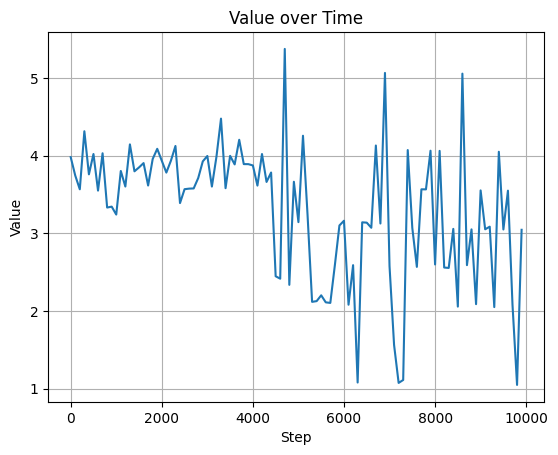

In [9]:
import matplotlib.pyplot as plt
# x 軸：資料點編號（第幾次）
x = list(range(0,len(Error_list)*100, 100))
# y 軸：每個值
y = Error_list
# 畫圖
plt.plot(x, y)  # 折線圖 + 每點畫圈
plt.xlabel("Step")
plt.ylabel("Value")
plt.title("Value over Time")
plt.grid(True)
plt.show()

可以發現有隨著資料量增加訓練越來越好的趨勢。

# 補充：為什麼有時候訓練出來都是 0 向量

問 AI 的結果如下：

這是非常常見的現象，當你將訓練資料從增加時，模型的預測結果全變成 0，可能是以下幾個常見的機制失衡或錯誤導致的。


### 問題現象

例如：

* **訓練資料：** 10,000 筆 → 模型還會預測出接近正確的值
* **訓練資料：** 100,000 筆 → 模型幾乎只輸出 `0`（或其他固定值）

這代表：

* 模型沒有效學習到規律（可能卡在某個區域）
* 或者學習率太小、權重更新不動
* 或者資料不平衡、loss 消失


### 可能原因分析

1. **學習率太小 → 權重幾乎沒更新**

* 小資料量下小學習率還能跑
* 資料一多，梯度很小時根本沒辦法推動權重更新

✅ **對策：**

* 嘗試調整 `learning_rate`，例如從 `0.1` 提高到 `0.5`、`1.0` 甚至更高

```python
learning_rate = 0.5  # 試著加大看看效果
```

 2. **梯度消失（vanishing gradient）**

* 你用了 `sigmoid`，如果輸入太大或太小，導數會趨近 0
* 時間步過長 + sigmoid，導致梯度傳不回來

✅ **對策：**

* 替代激活函數（如 `tanh` 或 `ReLU`）
* 使用 clipped gradient（進階方法）
* 降低 binary\_dim 的數量或減少時間步數測試

3. **資料不平衡**

* 訓練資料中，可能大部分位元都為 `0`
* 模型學會「都預測 0」反而 loss 最小

 **對策：**

* 分析資料中各 bit 的 0/1 分布
* 平衡輸出資料、加權 loss



4. **模型訓練不夠輪（太早看結果）**

* 資料多但 epoch 數太少
* 每筆資料更新一次，epoch 效果變小

**對策：**

* 多跑幾輪 epoch（例：多次迴圈訓練資料）

```python
for epoch in range(10):
    for a, b, c in data:
        ...
```



5. **整批資料記憶體吃不消（爆量時變慢、失效）**

* 如果你用 numpy，每筆 forward/backward 都是單筆處理，100,000 筆會非常慢
* 可能導致某些變數錯誤、梯度計算壞掉而沒注意到

 **對策：**

* 測試小批次先確保正確性
* 或先試 20,000 → 50,000 → 再到 100,000 筆觀察效應

---

###  建議步驟（Debug 順序）

1.  **先確認資料分布**：

   ```python
   ones = sum([sum(c) for _, _, c in data])
   zeros = len(data) * len(data[0][2]) - ones
   print(f"1 的比例: {ones / (ones + zeros):.4f}")
   ```

2.  **加入預測值與 loss 的紀錄與觀察（是否都變成 0）**

3.  **試著多跑幾次 epoch**：

   ```python
   for epoch in range(5):
       for a, b, c in data:
           ...
   ```

4. **調整學習率**

   ```python
   learning_rate = 0.5  # 可嘗試 1.0
   ```

5. **嘗試替代 sigmoid 為 tanh（適合雙向輸出）**

---

### 最簡單測法（加速 debug）

試用以下條件：

* `learning_rate = 0.5`
* `binary_dim = 8`
* `hidden_dim = 16`
* 資料量減少，觀察漸變情況


###  總結對策表：

| 問題               | 解法建議                         |
| ---------------- | ---------------------------- |
| 資料太多但沒多輪訓練       | 多跑幾個 epoch                   |
| 學習率太小            | 提高 learning rate 到 0.5 或 1.0 |
| 梯度消失（使用 sigmoid） | 試 `tanh`、`ReLU` 或梯度剪裁        |
| 資料偏向 0           | 加入 loss 權重或數據平衡              |
| 權重沒初始化或錯誤        | 確認隨機初始化沒被覆蓋                  |





# 補充：RNN 應用

## 文字資料應用原理

文字是一種有順序的資料（句子 = 單字序列），例如：

> "I love time series."

每個字對整體句子的意思都有影響。RNN 透過「記憶」前面的資訊，來理解目前的輸入。

以模型結構來說，$\{x_t\}$便是正確的文字序列資料(ex. "I love time series.")

RNN 處理文字資料的基本流程：

1. **文字預處理**

   * 將句子分詞（tokenization）
   * 轉成數字（word to index）
   * 建立詞嵌入（embedding）

2. **建構 RNN 模型**

   * 輸入層：嵌入向量
   * 隱藏層：RNN / LSTM / GRU
   * 輸出層：看任務類型（分類、預測下一字、標註）

3. **模型訓練與推論**

   * 使用標準的損失函數（如交叉熵）
   * 訓練完模型後就能進行文字生成、分類或翻譯等任務

應用場景舉例：

| 任務              | RNN 的應用方式                                    |
| --------------- | -------------------------------------------- |
| 文字分類         | 輸入整個句子，最後用 RNN 最後一個 hidden state 做分類（如情感分析）  |
|  語言模型 / 文字生成  | 給定前面幾個字，RNN 預測下一個字（或詞）                       |
|  機器翻譯         | 使用 Encoder-Decoder 架構（雙 RNN），前半編碼原始語句，後半生成翻譯 |
|  命名實體識別（NER） | 每個字都產出一個預測，使用 bidirectional RNN 處理前後文        |
